# Classification

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

The primary goal of this notebook is to review ways to evaluate binary classification algorithms.  We'll start with the confusion matrix and the metrics that are derived from it, including accuracy, sensitivity, specificity, predictive value, false positive rate, and false negative rate.

Then...

Here are the libraries and functions I'll use for my analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [3]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts(dropna=False).sort_index()

## Machine Bias

In the previous notebook...

## Data

[This repository](https://github.com/propublica/compas-analysis) the data and analysis pipeline described on [this web page](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [4]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell read the data file:

In [5]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

In [6]:
high_risk = (cp['decile_score'] > 4)
high_risk.name = 'HighRisk'
values(high_risk)

False    3897
True     3317
Name: HighRisk, dtype: int64

`new_charge_2` is a Boolean Series that is `True` for defendants who were charged with another crime within two years.

In [7]:
new_charge_2 = (cp['two_year_recid'] == 1)
new_charge_2.name = 'NewCharge2'
values(new_charge_2)

False    3963
True     3251
Name: NewCharge2, dtype: int64

In [8]:
white = (cp['race'] == 'Caucasian')
white.name = 'white'
values(white)

False    4760
True     2454
Name: white, dtype: int64

In [9]:
black = (cp['race'] == 'African-American')
black.name = 'black'
values(black)

False    3518
True     3696
Name: black, dtype: int64

In [10]:
def make_matrix(cp, subgroup, threshold=4):
    """Make a confusion matrix.
    
    cp: DataFrame
    subgroup: Boolean Series
    
    returns: DataFrame containing the confusion matrix
    """
    a = np.where(cp['decile_score'] > threshold, 
                 'Positive', 
                 'Negative')
    high_risk = pd.Series(a, name='Predicted')
    
    a = np.where(cp['two_year_recid'] == 1, 
                 'Condition', 
                 'No Condition')
    new_charge_2 = pd.Series(a, name='Actual')

    matrix = pd.crosstab(high_risk[subgroup], new_charge_2[subgroup])
    matrix.sort_index(axis=0, ascending=False, inplace=True)
    
    return matrix

## Metrics



In [11]:
def percent(x, y):
    """Compute the percentage `x/(x+y)*100`.
    """
    return x / (x+y) * 100

In [12]:
def predictive_value(m):
    """Compute positive and negative predictive value.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

In [13]:
def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    return sens, spec

In [14]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

In [15]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = df.to_numpy().flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

## All metrics

The following function takes a confusion matrix and computes the metrics from the 

In [16]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, prev
    df.index.name = name
    return df

## The WaPo response

After the ProPublica article, the Washington Post (WaPo) published a response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)"

The WaPo article summarizes the ProPublica article and the response from Northpointe, the company that makes COMPAS.  

* ProPublica claims that COMPAS is unfair because "among defendants who ultimately did not reoffend, blacks were more than twice as likely as whites to be classified as medium or high risk."

* Northpoint claims that COMPAS is fair because "scores mean essentially the same thing regardless of the defendant’s race. For example, among defendants who scored a seven on the COMPAS scale, 60 percent of white defendants reoffended, which is nearly identical to the 61 percent of black defendants who reoffended."

So ProPublica and Northpoint are invoking different definitions of "fair".

In the previous notebook we explored the first definition of "fair" by computing error rates (false positive and false negative) for white and black defendants.

In this notebook, we'll explore the second definition, which is called "calibration".

## Calibration

The WaPo article includes this figure, which shows "white and black defendants with the same risk score are roughly equally likely to reoffend."

<img width=90%, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/calibration1.png'>

To understand this figure, let's start by replicating it.

The following function groups defendants by decile score and computes recidivism rate in each group.

In [17]:
def calibration_curve(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

The following figure shows this calibration curve for all defendants and broken down by race.

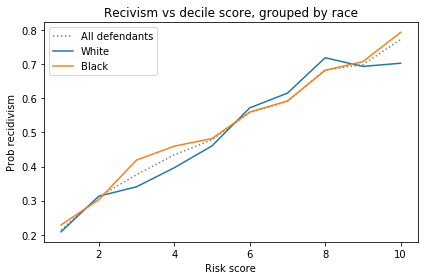

In [18]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_white = calibration_curve(cp[white])
cal_white.plot(label='White')

cal_white = calibration_curve(cp[black])
cal_white.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Prob recidivism',
         title='Recivism vs decile score, grouped by race')
plt.legend();

This figure shows that people with higher scores have higher probabilities of recidivism.  In that sense COMPAS works as intended; people with higher risk scores are substantially more likely to be arrested again.

Furthermore, the test is equally calibrated for black and white defendants; in each risk group, the probability of recidivism is about the same for black and white defendants.

The WaPo article explains why this is important:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

So we want a test that has the same predictive value for all groups, and we want a test that has the same error rates for all groups.  

But there's the problem: as the WaPo article explains, it is mathematically impossible to be fair, by both definitions, at the same time.

To see why, let's go back to the confusion matrix.

## Matrices and metrics

As we saw in the previous notebook, here are the confusion matrices for white and black defendants.

In [19]:
matrix_white = make_matrix(cp, white)
matrix_white

Actual,Condition,No Condition
Predicted,,
Positive,505,349
Negative,461,1139


In [20]:
matrix_black = make_matrix(cp, black)
matrix_black

Actual,Condition,No Condition
Predicted,,
Positive,1369,805
Negative,532,990


And here are the metrics we computed from the confusion matrices:

In [21]:
metrics_white = compute_metrics(matrix_white, 
                                'White defendants')
metrics_white

,Percent
White defendants,
FP rate,23.454301
FN rate,47.722567
PPV,59.133489
NPV,71.187500
Prevalence,39.364303


In [22]:
metrics_black = compute_metrics(matrix_black, 
                                'Black defendants')
metrics_black

,Percent
Black defendants,
FP rate,44.846797
FN rate,27.985271
PPV,62.971481
NPV,65.045992
Prevalence,51.433983


If we look at the error rates , it seems like COMPAS is biased against black defendants:

* Their false positive rate is higher (45% vs 23%): among people who will not recidivate, black defendants are more likely to be classified high risk.

* Their false negative rate is lower (28% vs 48%): among people who *will* recidivate, black defendants are less likely to be classified low risk.

But if we look at the the predictive values (PPV and NPV) it seems like COMPAS is biased in favor of black defendants:

* Among people in the high risk group, black defendants are more likely to be arrested again (63% vs 59%).

* Among people in the low risk group, black defendants are less likely to "survive" two years without being arrested again (65% vs 71%).

It seems like we should be able to fix these problems, but it turns out that we can't.  

* If we make the error rates more equal, we make the predictive values more unfair, and the other way around; 

* If we make the predictive values more equal, we make the error rates more unfair.

Fundamentally, the problem is that the prevalence of recidivism is different in the two groups: about 39% of white defendants were arrested again, compared to 51% of black defendants.

As long as that's the case (for any two groups) the predictive values and error rates can't be "fair" at the same time.

To see why, consider this: the confusion matrix has four numbers in it, but they have to add up to 100%, so if you give me any three elements of the matrix, I can compute the fourth.

In the same way, if you provide any three (independent) metrics, I can compute the elements of the matrix, and any other metrics.  Specifically:

* Given prevalence, PPV and NPV, we can compute the confusion matrix and the error rates.

* Given prevalence, FPR and FNR, we can compute the confusion matrix and the predictive values.

We could do the algebra by hand, but it is easier (and probably more reliable) to use SymPy.

Here are the symbols we'll use:

In [192]:
from sympy import symbols, Eq, solve

tn, fp, fn, tp = symbols('tn, fp, fn, tp')
ppv, npv, prev = symbols('ppv, npv, prev')
fpr, fnr = symbols('fpr, fnr')

And here are the equations that relate the metrics to the elements of the confusion matrix.

In [193]:
eq1 = Eq(prev, tp+fn)
eq2 = Eq(fpr, fp / (fp+tn))
eq3 = Eq(fnr, fn / (fn+tp))
eq4 = Eq(ppv, tp / (tp+fp))
eq5 = Eq(npv, tn / (tn+fn))
eq6 = Eq(tn+fp+fn+tp, 1)

We can use `solve` to get expressions for the elements of the confusion matrix in terms of `ppv`, `npv`, and `prev`:

In [199]:
soln1 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, fpr, fnr])
soln1[0]

(ppv*(npv + prev - 1)/(npv + ppv - 1),
 -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
 -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
 npv*(ppv - prev)/(npv + ppv - 1),
 (ppv - 1)*(npv + prev - 1)/((prev - 1)*(npv + ppv - 1)),
 -(npv - 1)*(ppv - prev)/(prev*(npv + ppv - 1)))

We can also solve for the elements of the confusion matrix in terms of `fpr`, `fnr`, and `prev`:

In [200]:
soln2 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, ppv, npv])

soln2[0]

(prev*(1 - fnr),
 fpr*(1 - prev),
 fnr*prev,
 (fpr - 1)*(prev - 1),
 prev*(fnr - 1)/(fnr*prev + fpr*prev - fpr - prev),
 (fpr - 1)*(prev - 1)/(fnr*prev + fpr*prev - fpr - prev + 1))

The following function takes `ppv`, `npv`, and `prev` and uses the expressions from `soln1` to compute a confusion matrix with those metrics.

In [201]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value
    npv: negative predictive value
    prev: prevalence
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

To test it, I'll use metrics from the confusion matrix for all defendants.

In [202]:
all_defendants = np.ones_like(white)
matrix_all = make_matrix(cp, all_defendants)
metrics_all = compute_metrics(matrix_all, 'All defendants')
metrics_all

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


I'll extract PPV, NPV, and prevalence.

In [218]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

Given those values, we can reconstruct the confusion matrix and compute the metrics again.

In [219]:
matrix = constant_predictive_value(ppv, npv, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point error.

In [220]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,0.000000e+00
NPV,-1.421085e-14
Prevalence,0.000000e+00


So that confirms that we can use PPV, NPV and prevalence to compute FPR and FNR.

Now let's see what happens if we hold PPV and NPV constant, and vary prevalence.  First I'll extract the prevalence of recidivism for black defendants:

In [206]:
prev = metrics_black['Percent']['Prevalence']
prev

51.433982683982684

Using this prevalence, and holding PPV and NPV constant, we can compute error rates:

In [207]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(53.40360542740529, 19.955904234916293)

FPR is substantially higher, and FNR substantially lower, compared to the error rates with lower prevalence.

We can do the same analysis for white defendants.

In [208]:
prev = metrics_white['Percent']['Prevalence']

In [209]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(17.254472103643895, 57.81054940714234)

When prevalence is lower, the false positive rate is higher and the false negative rate lower.

## The constant predictive value model

To show these effects more clearly, I'll sweep through a range of prevalences, from 30% to 60%, and plot the error rates we get if we hold predictive values constant.

In [210]:
ppv, npv = predictive_value(matrix_all)
prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)
    
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

In [211]:
def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

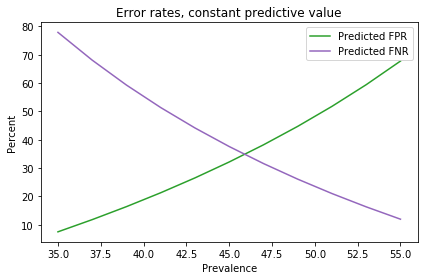

In [212]:
plot_cpv_model(pred_er)
plt.legend();

As prevalence increases, false positive rates increase quickly.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant prediction model again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [213]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
39.364303,23.454301,47.722567
45.065151,32.349230,37.403876
51.433983,44.846797,27.985271


In [214]:
actual_er['fpr']

39.364303    23.454301
45.065151    32.349230
51.433983    44.846797
Name: fpr, dtype: float64

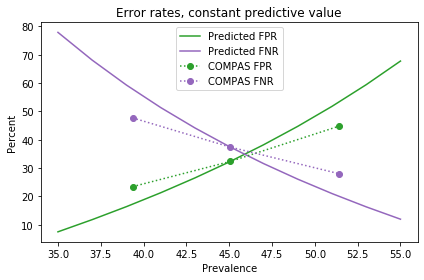

In [215]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

For higher-prevalence groups:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For lower-prevalence groups:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I will call "tempered", that is, less sensitive to variation in prevalence between groups.


## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [226]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate
    fnr: false negative rate
    prev: prevalence
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

To test it, we can extract metrics for all defendants:

In [227]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)

And use them to compute the other metrics:

In [228]:
matrix = constant_error_rates(fpr, fnr, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


And use the confusion matrix to compute the other metrics.

In [229]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,-7.105427e-15
NPV,1.421085e-14
Prevalence,0.000000e+00


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [231]:
fpr, fnr = error_rates(matrix_all)
prevalences = np.linspace(35, 65, 11)

pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)
    
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


The following function plots the results.

In [242]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C3')
    pred_pv['npv'].plot(label='Predicted PPV', color='C9')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

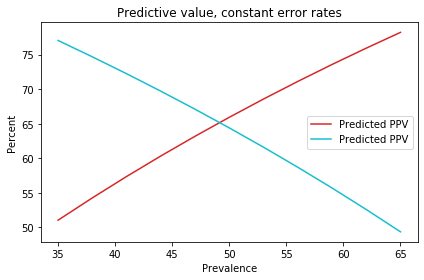

In [245]:
plot_cer_model(pred_pv)
plt.legend();

As prevalence increases, so does positive predictive value.

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant error rate again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [ ]:
def plot_ppv_npv(m):
    """Plot predictive values versus prevalence.
    
    m: confusion matrix
    """
    prev = prevalence(m)
    ppv, npv = predictive_value(m)
    plt.plot(prev, ppv, 'o', color='C0')
    plt.plot(prev, npv, 'o', color='C2')

In [ ]:
plot_ppv_npv(matrix_all)
plot_ppv_npv(matrix_black)
plot_ppv_npv(matrix_white)

plot_cer_model()

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.

An ideal test should have equal predictive value in all groups; that is, two people with the same risk score should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk.

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Specifically, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

### More data, more details

In this section I read the detailed dataset available from [this repository](https://github.com/propublica/compas-analysis) and run validation checks.

In [ ]:
# Uncomment and run this cell once to download the data.
# Then comment it again so you don't download it every time you run the notebook.
# !wget 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

In [ ]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.head()

In [ ]:
cp.shape

In [ ]:
for col in cp.columns:
    print(col)

The following functions compute value counts and percentages for various variables.

In [ ]:
def make_dataframe(series, *columns):
    """Make a Series into a DataFrame with one column.
    
    So it looks better in Jupyter.
    
    series: Series
    columns: column name(s)
    
    returns: DataFrame
    """
    df = pd.DataFrame(series.values,
                      index=series.index,
                      columns=columns)
    df.index.name = series.name
    return df

def counts(df, var):
    """Compute counts for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts()
    return make_dataframe(series, 'Count')

def percentages(df, var):
    """Compute percentages for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts() / len(df) * 100
    return make_dataframe(series, 'Percentage')

Breakdown by age

In [ ]:
counts(cp, 'age_cat')

In [ ]:
percentages(cp, 'age_cat')

Breakdown by race

In [ ]:
counts(cp, 'race')

In [ ]:
percentages(cp, 'race')

Breakdown by sex

In [ ]:
counts(cp, 'sex')

In [ ]:
percentages(cp, 'sex')

Breakdown by recidivism

In [ ]:
counts(cp, 'two_year_recid')

In [ ]:
percentages(cp, 'two_year_recid')

Breakdown by risk category

In [ ]:
counts(cp, 'score_text')

In [ ]:
percentages(cp, 'score_text')

The following function computes cross-tabulations.

In [ ]:
def crosstab(df, index, columns):
    """Compute a cross-tabulation.
    
    df: DataFrame
    index: variable(s) that will label the rows
    columns: variable(s) that will label the columns
    
    returns: DataFrame
    """

    xtab = df.pivot_table(index=index, 
                          columns=columns,
                          values='id',
                          aggfunc='count')
    
    return xtab

Breakdown by sex and race

In [ ]:
xtab = crosstab(cp, 'sex', 'race')

Breakdown by age and race

In [ ]:
xtab = crosstab(cp, 'age_cat', 'race')

Breakdown by age and sex

In [ ]:
xtab = crosstab(cp, 'age_cat', 'sex')

Distribution of decile scores for black defendants.

In [ ]:
cp.loc[cp.race=='African-American', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='Black defendant decile scores',
         ylim=[0, 700])

Distribution of decile scores for white defendants.

In [ ]:
cp.loc[cp.race=='Caucasian', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='White defendant decile scores',
         ylim=[0, 700])

Cross tabulation of decile score and race.

In [ ]:
crosstab(cp, 'decile_score', 'race')

Cross tabulation of decile score and age group.

In [ ]:
crosstab(cp, 'decile_score', 'age_cat')

Here's the confusion matrix with all three score categories.

In [ ]:
crosstab(cp, 'two_year_recid', 'score_text')

To make sure I've got the data right, I'll reproduce the confusion matrices from the article.

In [ ]:
def compute_matrix(df):
    """Compute a confusion matrix from data.
    
    df: DataFrame
    
    returns: confusion matrix
    """
    high = cp.score_text.isin(['Medium', 'High']).astype(int)
    return crosstab(df, 'two_year_recid', high)

All defendants.

In [ ]:
compute_matrix(cp)

And the differences are 0.

In [ ]:
matrix_all - compute_matrix(cp).values

Black defendants.

In [ ]:
black = cp[cp.race=='African-American']
compute_matrix(black)

In [ ]:
matrix_black - compute_matrix(black).values

White defendants.

In [ ]:
white = cp[cp.race=='Caucasian']
compute_matrix(white)

In [ ]:
matrix_white - compute_matrix(white).values

### Comparing reality to the CPV model

In this section I'll compare actual PPV and FPR for a variety of subgroups to the values we would expect based on the CPV model; that is, a model where the predictive values are the same for all groups.

The following function groups defendants by `group_vars` and returns a table with one row for each group.

In [ ]:
def make_table(df, group_vars, expected_ppv, expected_npv):
    """Make a table with one line per group.
    
    df: DataFrame
    group_vars: string or list of string variable names
    expected_ppv: 
    expected_npv:
    
    returns: table
    """
    # make the DataFrame
    columns = ['count', 'prevalence',
               'actual PPV', 'actual NPV', 'actual FNR',
               'actual FPR', 'expected FPR', 'difference']
    columns = group_vars + columns 

    table = pd.DataFrame(columns=columns)

    # loop through the groups
    grouped = df.groupby(group_vars)
    for i, (name, group) in enumerate(grouped):
        if not isinstance(name, tuple):
            name = name,
        
        # size of group
        count = len(group)
        
        # compute metrics
        matrix = compute_matrix(group)
        prev = prevalence(matrix)
        actual_ppv, actual_npv = predictive_value(matrix)
        actual_fpr, actual_fnr = error_rates(matrix)

        # generate the CPV matrix
        cpv = constant_predictive_value(prev, 
                          expected_ppv, expected_npv)

        # get the expected error rates
        expected_fpr, _ = error_rates(cpv * 100)
        
        # for very low and high prevalences, it might
        # not be possible to achieve given predictive values
        if expected_fpr < 0:
            expected_fpr = 0

        if expected_fpr > 100:
            expected_fpr = 100

        # difference between actual and expected
        diff = actual_fpr - expected_fpr

        # add a row to the table
        row = name + (count, prev,
                      actual_ppv, actual_npv, actual_fnr,
                      actual_fpr, expected_fpr, diff)
        
        table.loc[i] = row
        
    # sort the table by prevalence
    table.sort_values(by='prevalence', inplace=True)
    return table

In [ ]:
subset = cp[cp.race.isin(['African-American', 'Caucasian'])]
subset.shape

Here's the breakdown by age category.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat']
table1 = make_table(subset, group_vars, ppv, npv)

Again, the actual behavior of the test is tempered, compare to the CPV model; that is, the results are less extreme than the model expects.

Here's the breakdown by race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race']
table2 = make_table(subset, group_vars, ppv, npv)

The false positive rate for whites is higher than we would expect if predictive value were the same for all groups.

The false positive rate for blacks is lower than we would expect.

Here's the breakdown by sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['sex']
table3 = make_table(subset, group_vars, ppv, npv)

The false positive rate for women is substantially higher than what we would expect in the CPV model, which is consistent with the calibration results in the previous section.

Here's the breakdown by age and race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race']
table4 = make_table(subset, group_vars, ppv, npv)

Breakdown by age and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'sex']
table5 = make_table(subset, group_vars, ppv, npv)

Breakdown by race and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race', 'sex']
table6 = make_table(subset, group_vars, ppv, npv)

Breakdown by age, race, and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race', 'sex']
table7 = make_table(subset, group_vars, ppv, npv)

Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

In [ ]:
tables = [table1, table2, table3, table4, table5, table6, table7];

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [ ]:
def plot_table_var(table, var, color):
    """Plot one data point per row.
    
    table: DataFrame
    var: which metric to plot
    color: string
    """
    for _, row in table.iterrows():
        alpha = 0.8 if row['count'] > 200 else 0.3

        plt.plot(row['prevalence'], row[var],
                 'o', color=color, alpha=alpha)

Here's what the results look like for FPR.

In [ ]:
fp_rates.plot(label='Expected FPR, constant CPV',
              color='C1')
plt.axhline(fpr, linestyle='dotted', 
            label='Expected FPR, constant FPR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FPR', 'C1')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False positive rates by subgroup')

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

In [ ]:
ppv_rates.plot(label='Expected PPV, constant FPR', color='C0')
plt.axhline(ppv, linestyle='dotted', 
            label='Expected PPV, constant PPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual PPV', 'C0')
    
decorate(xlabel='Prevalence',
         ylabel='Rate',
         title='Positive predictive value by subgroup')

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

In [ ]:
fn_rates.plot(label='Expected FNR, constant CPV',
              color='C4')
plt.axhline(fnr, linestyle='dotted', 
            label='Expected FNR, constant FNR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FNR', 'C4')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False negative rates by subgroup')

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

In [ ]:
npv_rates.plot(label='Expected NPV, constant FPR', color='C2')
plt.axhline(npv, linestyle='dotted', 
            label='Expected NPV, constant NPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual NPV', 'C2')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='Negative predictive value by subgroup')

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.

### Individual FPR

In [ ]:
from scipy.interpolate import interp1d

def crossing(series, value, **options):
    """Find where a function crosses a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.values, series.index, **options)
    return interp(value)

def interpolate(series, value, **options):
    """Evaluate a function at a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.index, series.values, **options)
    return interp(value)

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
crossing(cal_all, 0.4)

In [ ]:
crossing(cal_all, 0.7)

In [ ]:
interpolate(cal_all, 3.4)

In [ ]:
interpolate(cal_all, 9)

In [ ]:
def make_error_dist(std_dev):
    """Make a discrete Gaussian distribution.
    
    std_dev: standard deviation
    
    returns: Series that maps errors to probabilities
    """
    errors = np.linspace(-3, 3, 21)
    prob_error = np.exp(-(errors/std_dev)**2)
    prob_error /= np.sum(prob_error)
    error_dist = pd.Series(prob_error, index=errors)
    return error_dist

In [ ]:
error_dist = make_error_dist(std_dev=2)
error_dist.plot(label='')
decorate(xlabel='Error (score)',
         ylabel='Probability')

In [ ]:
def individual_fpr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'not low' | error
        prob_positive = 0 if score < thresh else 1

        # probability of being a false positive | error
        prob_fp = prob_positive * (1-actual_prob_recid)
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fpr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fpr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FPR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fpr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fpr = individual_fpr(prob_recid, cal, thresh, std_dev)
        prob_fpr_series[prob_recid] = fpr
    return prob_fpr_series

In [ ]:
s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false positive')

In [ ]:
def individual_fpr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifpr = individual_fpr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifpr
    return total_prob

In [ ]:
individual_fpr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifpr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fpr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifpr_series = pd.Series(t, scores)
    return ifpr_series

In [ ]:
thresh = 4.5

s = make_ifpr_series(cal_all, thresh, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = make_ifpr_series(cal_all, thresh, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
def assign_individual_fpr(df, cal, thresh, std_dev):
    """Assign individual FPRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifpr_series = make_ifpr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifpr'] = [ifpr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_cdf(series):
    """Make a CDF."""
    counts = series.value_counts().sort_index()
    counts /= counts.sum()
    return counts.cumsum()

def plot_cdf(cdf, **options):
    """Plot a CDF as a step function."""
    plt.step(cdf.index, cdf.values, where='post', **options)

In [ ]:
cdf_ifpr = make_cdf(cp.ifpr)

In [ ]:
plot_cdf(cdf_ifpr, label='All')

decorate(xlabel='Individual probability of false positive', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
black = cp[cp.race=='African-American']
white = cp[cp.race=='Caucasian']

thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifpr_series(cal_black, thresh, std_dev)
s.plot(label='FPR, black')

cal_white = calibration_curve(white)
s = make_ifpr_series(cal_white, thresh, std_dev)
s.plot(label='FPR, white')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
male = cp[cp.sex=='Male']
female = cp[cp.sex=='Female']

thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifpr_series(cal_male, thresh, std_dev)
s.plot(label='FPR, male')

cal_female = calibration_curve(female)
s = make_ifpr_series(cal_female, thresh, std_dev)
s.plot(label='FPR, female')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

### Individual FNR

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
def individual_fnr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'low' | error
        prob_negative = 0 if score >= thresh else 1

        # probability of being a false negative | error
        prob_fp = prob_negative * actual_prob_recid
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fnr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fnr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FNR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fnr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fnr = individual_fnr(prob_recid, cal, thresh, std_dev)
        prob_fnr_series[prob_recid] = fnr
    return prob_fnr_series

In [ ]:
s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false negative')

In [ ]:
def individual_fnr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifnr = individual_fnr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifnr
    return total_prob

In [ ]:
individual_fnr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifnr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fnr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifnr_series = pd.Series(t, scores)
    return ifnr_series

In [ ]:
thresh = 4.5

s = make_ifnr_series(cal_all, thresh, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = make_ifnr_series(cal_all, thresh, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
def assign_individual_fnr(df, cal, thresh, std_dev):
    """Assign individual FNRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifnr_series = make_ifnr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifnr'] = [ifnr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
cdf_ifnr = make_cdf(cp.ifnr)

In [ ]:
plot_cdf(cdf_ifnr, label='All')

decorate(xlabel='Individual probability of false negative', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifnr_series(cal_black, thresh, std_dev)
s.plot(label='FNR, black')

cal_white = calibration_curve(white)
s = make_ifnr_series(cal_white, thresh, std_dev)
s.plot(label='FNR, white')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifnr_series(cal_male, thresh, std_dev)
s.plot(label='FNR, male')

cal_female = calibration_curve(female)
s = make_ifnr_series(cal_female, thresh, std_dev)
s.plot(label='FNR, female')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

### What would it take?

In this section I explore what it would take to make a test with the same false positive rate for all groups.

In [ ]:
def fpr_thresh(df, thresh):
    df = df.copy()
    df['high'] = df.decile_score >= thresh
    matrix_all = crosstab(df, 'two_year_recid', 'high')
    fpr, fnr = error_rates(matrix_all)
    return fpr

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(white, 5)

In [ ]:
def sweep_thresh(df):
    threshes = range(2,10)
    sweep = pd.Series(index=threshes)
    for thresh in threshes:
        sweep[thresh] = fpr_thresh(df, thresh)
        
    return sweep

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(cp).plot(label='All')
sweep_thresh(black).plot(label='Black')
sweep_thresh(white).plot(label='White')
decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
def find_threshold(group, fpr):
    series = sweep_thresh(group)
    xs = crossing(series.dropna(), fpr)
    return xs

In [ ]:
all_thresh = find_threshold(cp, 32.35)

In [ ]:
black_thresh = find_threshold(black, 32.35)

In [ ]:
white_thresh = find_threshold(white, 32.35)

In [ ]:
interpolate(calibration_curve(cp), all_thresh)

In [ ]:
interpolate(calibration_curve(cp), black_thresh)

In [ ]:
interpolate(calibration_curve(black), black_thresh)

In [ ]:
interpolate(calibration_curve(cp), white_thresh)

In [ ]:
interpolate(calibration_curve(white), white_thresh)

In [ ]:
black_male = black[black.sex=='Male']
black_male.shape

In [ ]:
black_female = black[black.sex=='Female']
black_female.shape

In [ ]:
old_black_female = black_female[black_female.age_cat=='Greater than 45']
old_black_female.shape

In [ ]:
old_white_female = cp[(cp.age_cat=='Greater than 45') &
                      (cp.sex=='Female') &
                      (cp.race=='Caucasian')]
old_white_female.shape

In [ ]:
young_black_male = cp[(cp.age_cat=='Less than 25') &
                      (cp.sex=='Male') &
                      (cp.race=='African-American')]
young_black_male.shape

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(black_female, 5)

In [ ]:
fpr_thresh(old_black_female, 5)

In [ ]:
fpr_thresh(black_male, 5)

In [ ]:
fpr_thresh(young_black_male, 5)

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_male).plot(label='Black male')
sweep_thresh(young_black_male).plot(label='Young black male')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_female).plot(label='Black female')
sweep_thresh(old_black_female).plot(label='Old black female')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
ybm_thresh = find_threshold(young_black_male, 32.35)

In [ ]:
obf_thresh = find_threshold(old_black_female, 32.35)

In [ ]:
interpolate(calibration_curve(cp), ybm_thresh)

In [ ]:
interpolate(calibration_curve(cp), obf_thresh)

To see what this kind of unfairness looks like, I'll generate the same figure, grouping defendants by sex.

In [ ]:
male = (cp['sex'] == 'Male')
male.mean()

In [ ]:
female = (cp['sex'] == 'Female')
female.mean()

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_male = calibration_curve(cp[male])
cal_male.plot(label='Male')

cal_female = calibration_curve(cp[female])
cal_female.plot(label='Female')

decorate(xlabel='Risk score',
         ylabel='Prob recidivism',
         title='Recivism vs decile score, grouped by sex')
plt.legend();

For all risk scores, female defendants are substantially less likely to recidivate than male defendants.

Or, reading the graph the other way, female defendants are given decile scores 1-2 points higher than male defendants with the same actual risk of recidivism.

## AUC

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

## ROC

One way to do that is to adjust the threshold so the error rates are the same in both groups.

The following function loops through the possible threshold for the low and high risk groups.  For each threshold, it makes the confusion matrix and computes sensitivity and specificity.

In [ ]:
thresholds = range(1, 10)
for threshold in thresholds:
    matrix = make_matrix(cp, white, threshold)
    t = sens_spec(matrix)
    print(threshold, t)

When the threshold is low, almost everyone is in the high risk group; in that case:

* Sensitivity is high because most recidivists are in the high risk group, but 

* Specificity is low because most non-recidivists are *also* in the high risk group.

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* Sensitivity is low because most recidivists are in the low risk group, but

* Specificity is high because most non-recidivists are *also* in the low risk group.

One way to visualize these results is to plot sensitivity versus FPR (which is the complement of specificity) for a range of thresholds.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function computes the ROC curve for a given subset of the data:

In [ ]:
def make_roc(cp, group):

    thresholds = range(1, 10)
    roc = pd.DataFrame(index=thresholds, 
                   columns=['sens', 'spec'])

    for threshold in thresholds:
        matrix = make_matrix(cp, group, threshold)
        roc.loc[threshold] = sens_spec(matrix)
    
    roc['fpr'] = 100 - roc['spec']
    
    return roc

In [ ]:
roc_white = make_roc(cp, white)
roc_white

In [ ]:
roc_black = make_roc(cp, black)
roc_black

In [ ]:
def plot_roc(roc):
    plt.plot(roc['fpr'], roc['sens'])

In [ ]:
plot_roc(roc_white)
plot_roc(roc_black)